In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle
import joblib

#preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# modeling
import xgboost as xgb
import itertools #grid search用
from sklearn.model_selection import KFold

#metrics
from sklearn.metrics import mean_squared_error

#progress bar
from tqdm.notebook import tqdm

import sys
sys.path.append('../src')
from util import simple_preprocess

#plot setting
import myplot
myplot.setting_myplot()

In [103]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows',100)
pd.set_option("display.max_seq_item",150)
pd.set_option("display.width",None)

In [104]:
os.listdir('../features/')

['0.26986_feature.pkl',
 '0.26993_feature.pkl',
 '0.26999_feature.pkl',
 'base.pkl',
 '前面道路の方位区分.pkl',
 '前面道路の方位区分_取引年.pkl',
 '前面道路区分.pkl',
 '前面道路区分_取引年.pkl',
 '形状区分.pkl',
 '形状区分_取引年.pkl',
 '所在地コード.pkl',
 '所在地コード_取引年.pkl',
 '用途区分.pkl',
 '用途区分_取引年.pkl',
 '駅名.pkl',
 '駅名_取引年.pkl']

In [105]:
with open('../features/base.pkl', 'rb') as f:
    full = pickle.load(f)

merge_file = [
    '前面道路の方位区分_取引年.pkl',
     '前面道路区分_取引年.pkl',
     '形状区分_取引年.pkl',
     '所在地コード_取引年.pkl',
     '用途区分_取引年.pkl',
     '駅名_取引年.pkl']

for file in merge_file:
    with open('../features/'+file, 'rb') as f:
        df = pickle.load(f)
        full = pd.concat([full,df],axis=1)

In [106]:
full.columns

Index(['id', '種類', '地域', '市区町村コード', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '間取り',
       '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的',
       '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '取引時点',
       '改装', '取引の事情等', 'y', 'adversarial', '間取り_Ｌ', '間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ',
       '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア', '間取り_スタジオ', '間取り_＋Ｋ',
       '間取り_missing', '間取り_num', '面積（㎡）_2000㎡以上', '土地の形状_rank', '建築年_西暦',
       '建物の構造_木造', '建物の構造_鉄骨造', '建物の構造_ＳＲＣ', '建物の構造_ＲＣ', '建物の構造_missing',
       '建物の構造_ブロック造', '建物の構造_軽量鉄骨造', '取引時点_年', '取引時点_四半期', '取引の事情等_関係者間取引',
       '取引の事情等_その他事情有り', '取引の事情等_他の権利・負担付き', '取引の事情等_missing', '取引の事情等_隣地の購入',
       '取引の事情等_瑕疵有りの可能性', '取引の事情等_調停・競売等', '取引の事情等_私道を含む取引', '用途_その他', '用途_倉庫',
       '用途_店舗', '用途_住宅', '用途_駐車場', '用途_作業場', '用途_工場', '用途_missing', '用途_共同住宅',
       '用途_事務所', '経過年月', '前面道路の方位区分_mean_取引年', '前面道路の方位区分_std_取引年',
       '前面道路の方位区分_count_取引年', '前面道路の方位区分_median_取引年', '前面道路区分_mean_取引年',
       '前面道路区分_std_取引年'

In [107]:
use_columns = ['id', '種類', '地域', '市区町村コード', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '面積（㎡）', '間口', '延床面積（㎡）', '今後の利用目的',
       '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）', '容積率（％）', '改装',
       'y', 'adversarial', '間取り_Ｌ', '間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ',
       '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア', '間取り_スタジオ', '間取り_＋Ｋ',
       '間取り_missing', '間取り_num', '面積（㎡）_2000㎡以上', '土地の形状_rank', '建築年_西暦',
       '建物の構造_ＳＲＣ', '建物の構造_ブロック造', '建物の構造_軽量鉄骨造', '建物の構造_ＲＣ', '建物の構造_木造',
       '建物の構造_鉄骨造', '建物の構造_missing', '取引時点_年', '取引時点_四半期', '取引の事情等_関係者間取引',
       '取引の事情等_瑕疵有りの可能性', '取引の事情等_その他事情有り', '取引の事情等_他の権利・負担付き',
       '取引の事情等_私道を含む取引', '取引の事情等_隣地の購入', '取引の事情等_missing', '取引の事情等_調停・競売等',
       '用途_工場', '用途_事務所', '用途_住宅', '用途_駐車場', '用途_共同住宅', '用途_店舗', '用途_倉庫',
       '用途_作業場', '用途_missing', '用途_その他','経過年月',
       '所在地コード_mean_取引年', '所在地コード_std_取引年', '所在地コード_count_取引年',
       '所在地コード_median_取引年', '駅名_mean_取引年', '駅名_std_取引年', '駅名_count_取引年',
       '駅名_median_取引年']
full = full[use_columns]

In [108]:
train = full[full['adversarial']==0]
test = full[full['adversarial']==1]
del full

In [109]:
pp_full,col_ins = simple_preprocess(train,test,"id","y")

object型のユニーク数： 種類 5 地域 5 地区名 1455 最寄駅：名称 657 今後の利用目的 7 前面道路：方位 10 前面道路：種類 15 都市計画 17 改装 3 
----------
shape: (356344, 70)
objects: 9


,種類,地域,地区名,最寄駅：名称,今後の利用目的,前面道路：方位,前面道路：種類,都市計画,改装
0,0,0,1404,628,3,0,0,1,1
1,0,0,1404,628,3,0,0,1,2
2,0,0,1404,628,1,0,0,1,2


floats: 6


,間口,前面道路：幅員（ｍ）,所在地コード_mean_取引年,所在地コード_std_取引年,駅名_mean_取引年,駅名_std_取引年
0,NaN,NaN,5.757475e+06,7.547589e+06,2062500.0,1.101737e+06
1,NaN,NaN,5.757475e+06,7.547589e+06,2062500.0,1.101737e+06
2,NaN,NaN,5.757475e+06,7.547589e+06,2062500.0,1.101737e+06


ints: 38


,市区町村コード,adversarial,間取り_Ｌ,間取り_Ｄ,間取り_Ｋ,間取り_＋Ｓ,間取り_Ｒ,間取り_メゾネット,間取り_オープンフロア,間取り_スタジオ,間取り_＋Ｋ,間取り_missing,面積（㎡）_2000㎡以上,建物の構造_ＳＲＣ,建物の構造_ブロック造,建物の構造_軽量鉄骨造,建物の構造_ＲＣ,建物の構造_木造,建物の構造_鉄骨造,建物の構造_missing,取引の事情等_関係者間取引,取引の事情等_瑕疵有りの可能性,取引の事情等_その他事情有り,取引の事情等_他の権利・負担付き,取引の事情等_私道を含む取引,取引の事情等_隣地の購入,取引の事情等_missing,取引の事情等_調停・競売等,用途_工場,用途_事務所,用途_住宅,用途_駐車場,用途_共同住宅,用途_店舗,用途_倉庫,用途_作業場,用途_missing,用途_その他
0,13101,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,13101,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,13101,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


float to int 15


,最寄駅：距離（分）,面積（㎡）,延床面積（㎡）,建ぺい率（％）,容積率（％）,間取り_num,土地の形状_rank,建築年_西暦,取引時点_年,取引時点_四半期,経過年月,所在地コード_count_取引年,所在地コード_median_取引年,駅名_count_取引年,駅名_median_取引年
0,1.0,55.0,NaN,80.0,600.0,2.0,9.0,1984.0,2017.0,4.0,33.0,61.0,2720000.0,4.0,1795000.0
1,5.0,20.0,NaN,80.0,500.0,1.0,9.0,2003.0,2017.0,4.0,14.0,61.0,2720000.0,4.0,1795000.0
2,3.0,45.0,NaN,80.0,500.0,1.0,9.0,2012.0,2017.0,3.0,5.0,61.0,2720000.0,4.0,1795000.0


bool型の列数 0
all: 68
int型とfloatだけどint型のユニーク数
市区町村コード 59 adversarial 2 間取り_Ｌ 2 間取り_Ｄ 2 間取り_Ｋ 2 間取り_＋Ｓ 2 間取り_Ｒ 2 間取り_メゾネット 2 間取り_オープンフロア 2 間取り_スタジオ 2 間取り_＋Ｋ 2 間取り_missing 2 面積（㎡）_2000㎡以上 2 建物の構造_ＳＲＣ 2 建物の構造_ブロック造 2 建物の構造_軽量鉄骨造 2 建物の構造_ＲＣ 2 建物の構造_木造 2 建物の構造_鉄骨造 2 建物の構造_missing 2 取引の事情等_関係者間取引 2 取引の事情等_瑕疵有りの可能性 2 取引の事情等_その他事情有り 2 取引の事情等_他の権利・負担付き 2 取引の事情等_私道を含む取引 2 取引の事情等_隣地の購入 2 取引の事情等_missing 2 取引の事情等_調停・競売等 2 用途_工場 2 用途_事務所 2 用途_住宅 2 用途_駐車場 2 用途_共同住宅 2 用途_店舗 2 用途_倉庫 2 用途_作業場 2 用途_missing 2 用途_その他 2 最寄駅：距離（分） 35 面積（㎡） 157 延床面積（㎡） 130 建ぺい率（％） 7 容積率（％） 18 間取り_num 8 土地の形状_rank 10 建築年_西暦 76 取引時点_年 15 取引時点_四半期 4 経過年月 78 所在地コード_count_取引年 112 所在地コード_median_取引年 561 駅名_count_取引年 33 駅名_median_取引年 2179 

In [110]:
categories = ['市区町村コード','adversarial',
              '間取り_Ｌ','間取り_Ｄ', '間取り_Ｋ', '間取り_＋Ｓ', '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア',
              '間取り_スタジオ', '間取り_＋Ｋ', '間取り_missing',
              '建物の構造_木造', '建物の構造_missing', '建物の構造_鉄骨造', '建物の構造_ＲＣ',
              '建物の構造_ＳＲＣ', '建物の構造_軽量鉄骨造', '建物の構造_ブロック造',
              '取引の事情等_調停・競売等', '取引の事情等_私道を含む取引', '取引の事情等_missing', '取引の事情等_関係者間取引',
              '取引の事情等_その他事情有り', '取引の事情等_他の権利・負担付き',
              '取引の事情等_隣地の購入', '取引の事情等_瑕疵有りの可能性',
              '用途_作業場', '用途_その他', '用途_missing','用途_倉庫', '用途_共同住宅', '用途_店舗', 
              '用途_住宅', '用途_駐車場', '用途_工場', '用途_事務所',
              '面積（㎡）_2000㎡以上'
             ]
for col in categories:
    pp_full[col] = pp_full[col].astype("category")

In [111]:
for col in pp_full.select_dtypes('category').columns:
    pp_full[col] = pp_full[col].astype(float)

In [112]:
print(pp_full.select_dtypes('category').columns)
print(pp_full.select_dtypes('int64').columns)
print(pp_full.select_dtypes(float).columns)

train = pp_full[pp_full['adversarial']==0]
test = pp_full[pp_full['adversarial']==1]

Index([], dtype='object')
Index(['id'], dtype='object')
Index(['種類', '地域', '市区町村コード', '地区名', '最寄駅：名称', '最寄駅：距離（分）', '面積（㎡）', '間口',
       '延床面積（㎡）', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画',
       '建ぺい率（％）', '容積率（％）', '改装', 'y', 'adversarial', '間取り_Ｌ', '間取り_Ｄ',
       '間取り_Ｋ', '間取り_＋Ｓ', '間取り_Ｒ', '間取り_メゾネット', '間取り_オープンフロア', '間取り_スタジオ',
       '間取り_＋Ｋ', '間取り_missing', '間取り_num', '面積（㎡）_2000㎡以上', '土地の形状_rank',
       '建築年_西暦', '建物の構造_ＳＲＣ', '建物の構造_ブロック造', '建物の構造_軽量鉄骨造', '建物の構造_ＲＣ',
       '建物の構造_木造', '建物の構造_鉄骨造', '建物の構造_missing', '取引時点_年', '取引時点_四半期',
       '取引の事情等_関係者間取引', '取引の事情等_瑕疵有りの可能性', '取引の事情等_その他事情有り',
       '取引の事情等_他の権利・負担付き', '取引の事情等_私道を含む取引', '取引の事情等_隣地の購入', '取引の事情等_missing',
       '取引の事情等_調停・競売等', '用途_工場', '用途_事務所', '用途_住宅', '用途_駐車場', '用途_共同住宅',
       '用途_店舗', '用途_倉庫', '用途_作業場', '用途_missing', '用途_その他', '経過年月',
       '所在地コード_mean_取引年', '所在地コード_std_取引年', '所在地コード_count_取引年',
       '所在地コード_median_取引年', '駅名_mean_取引年', '駅名_std_取引年', '駅名_count_取引年',
       '駅名_medi

In [113]:
xgb_modelling_params = {
    'alpha': [0.2], 
    'colsample_bytree': [0.4], 
    'lambda': [0.4], 
    'learning_rate': [0.1,0.05],
    'max_depth':[6,7,8],
    'eval_metric': ['rmse'], 
    'n_jobs': [-1], 
    'objective': ['reg:squarederror'], 
    'seed': [2020]}

In [71]:
#NULL_importanceを消す
drop_col = ['adversarial']
train = train.drop(drop_col,axis=1)
test = test.drop(drop_col,axis=1)

In [72]:
from tqdm.notebook import tqdm as tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

def make_dataset(df,ID,y):
    X = df.drop([ID,y],axis=1)
    y = df[y]
    return X,xgb.DMatrix(X,y)

def xgb_modelling(train,test,option_params,ID,y):
    
    #対数変換
    train[y] = np.log1p(train[y])
    
    #lightGBM用のデータセットに変換
    X_train,train_xgb = make_dataset(train,ID,y)
    test_xgb = xgb.DMatrix(test.drop([ID,y],axis=1))
    
    #ハイパラの選択肢を作る
    params = list(ParameterGrid(option_params))
    
    #GridSearchを行う
    min_score = np.inf
    for param in tqdm(params):
        result = xgb.cv(params=param,
                        num_boost_round=3000,
                        dtrain = train_xgb,
                        early_stopping_rounds=10,
                        stratified=False,
                        verbose_eval=100)
        
        metric = param['eval_metric']
        score = result['test-'+metric+'-mean'].min()
        if min_score > score:
            min_score = score
            min_score_iteration = len(result)
            best_hyper_param = param
        
        print(param,len(result))
        print(score)
    print(min_score,best_hyper_param)
        
    #このハイパラでもう一度学習予測
    bst = xgb.train(params=best_hyper_param,
                    num_boost_round=min_score_iteration,
                    dtrain=train_xgb,
                    verbose_eval=100)
    
    #テストデータに対して予測をする
    pred_test = bst.predict(test_xgb)
    pred_test = np.expm1(pred_test)
    pred_test[pred_test<0] == 0
    
    return pred_test,min_score,bst

In [73]:
predict,score,bst = xgb_modelling(train=train,
                                    test=test,
                                    option_params=xgb_modelling_params,
                                    ID='id',
                                    y='y')

[0]	train-rmse:2.90012+0.0017307	test-rmse:2.90025+0.00390539
[100]	train-rmse:0.279431+0.00248171	test-rmse:0.296436+0.00152559
[200]	train-rmse:0.258842+0.000497242	test-rmse:0.285168+0.000915877
[300]	train-rmse:0.247611+0.000613864	test-rmse:0.280731+0.00109767
[400]	train-rmse:0.239222+0.00068528	test-rmse:0.278553+0.00109769
[500]	train-rmse:0.232337+0.00051489	test-rmse:0.277063+0.00109076
[600]	train-rmse:0.225932+0.000397311	test-rmse:0.27601+0.00110916
[700]	train-rmse:0.220401+0.000471267	test-rmse:0.275287+0.00110214
[800]	train-rmse:0.215478+0.000456029	test-rmse:0.274762+0.00111209
[900]	train-rmse:0.210776+0.00070689	test-rmse:0.274342+0.00112446
[1000]	train-rmse:0.206218+0.000698517	test-rmse:0.274085+0.00109987
[1100]	train-rmse:0.201877+0.000941796	test-rmse:0.273839+0.00108621
[1200]	train-rmse:0.198003+0.000772692	test-rmse:0.273693+0.00105603
[1300]	train-rmse:0.194037+0.00065748	test-rmse:0.273516+0.00101947
[1400]	train-rmse:0.190498+0.000734313	test-rmse:0.2733

In [76]:
bst.best_iteration

1489

In [85]:
fi = pd.DataFrame(list(bst.get_fscore().values()),index=list(bst.get_fscore().keys()))
fi[fi[0] == 0].index.values

array([], dtype=object)

In [99]:
fi.sort_values(by=0,ascending=False)

,0
地区名,9698
面積（㎡）,9320
建築年_西暦,7924
間口,7904
駅名_mean_取引年,7483
駅名_std_取引年,7335
最寄駅：距離（分）,7082
駅名_median_取引年,7029
前面道路：幅員（ｍ）,6777
経過年月,6366


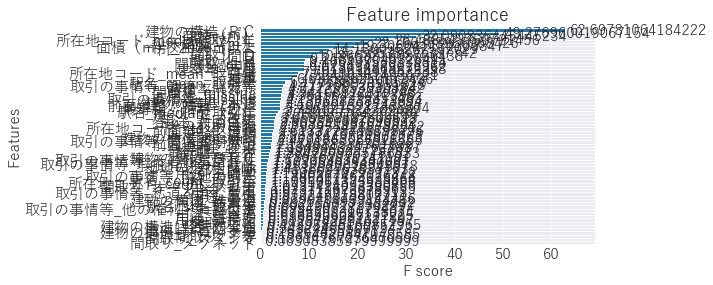

In [93]:
xgb.plot_importance(bst,ax=,height=1.0,importance_type='gain')
plt.show()

In [100]:
submission = pd.DataFrame(test['id'])
submission['y'] = predict
display(submission.loc[submission['y']<0,'y'])
submission.loc[submission['y']<0,'y'] = 0
display(submission)

382443   -0.040810
391081   -0.072126
391168   -0.152020
391169   -0.100484
Name: y, dtype: float32

,id,y
356344,1,33.583649
356345,2,16.638716
356346,3,261.397614
356347,4,26.694088
356348,5,70.166435
...,...,...
391183,34840,7.829359
391184,34841,1.362216
391185,34842,2.556217
391186,34843,10.061428


In [101]:
submission.to_csv('../submissions/sub_xgb' + str(round(score,5)) + '.csv',index=False)